### Importing Required Libraries

In [59]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from keras import layers, losses
from keras.models import Model, Sequential

### Downloading the Dataset

In [58]:
!wget http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv

--2024-06-29 10:31:00--  http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.141.207, 142.251.2.207, 74.125.137.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.141.207|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7877383 (7.5M) [text/csv]
Saving to: ‘ecg.csv.1’

ecg.csv.1           100%[===================>]   7.51M  --.-KB/s    in 0.04s   

2024-06-29 10:31:01 (187 MB/s) - ‘ecg.csv.1’ saved [7877383/7877383]



### Loading the Dataset

In [60]:
df = pd.read_csv('ecg.csv', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


### Splitting Data into Train and Test

In [61]:
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, :-1], df.iloc[:, -1], test_size=0.2, random_state=42)

### Normalizing the Data

In [62]:
normalizer = MinMaxScaler()
X_train = normalizer.fit_transform(X_train)
X_test = normalizer.transform(X_test)

### Distinguishing Normal and Anomalous Data

In [63]:
y_train = y_train.apply(lambda x: bool(x))
y_test = y_test.apply(lambda x: bool(x))

normal_train_data = X_train[y_train]
anomaly_train_data = X_train[~y_train]

normal_test_data = X_test[y_test]
anomaly_test_data = X_test[~y_test]

### Plotting a Sample from Normal and Anomalous Data

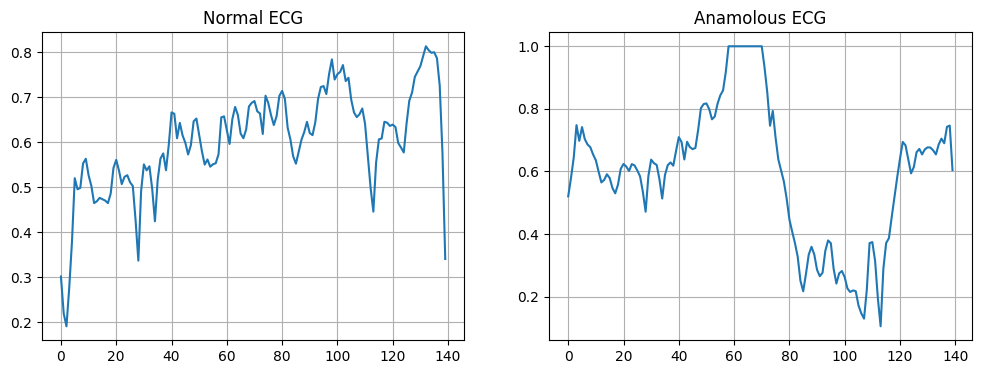

In [66]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(np.arange(140), normal_train_data[134])
plt.title('Normal ECG')
plt.grid()
plt.subplot(1, 2, 2)
plt.plot(np.arange(140), anomaly_train_data[134])
plt.title('Anomalous ECG')
plt.grid()
plt.show()

### Building AutoEncoder

In [67]:
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = Sequential([
      layers.Dense(32, activation='relu'),
      layers.Dropout(0.2),
      layers.Dense(16, activation='relu'),
      layers.Dropout(0.2),
      layers.Dense(8, activation='relu')
    ])
    self.decoder = Sequential([
      layers.Dense(16, activation='relu'),
      layers.Dropout(0.2),
      layers.Dense(32, activation='relu'),
      layers.Dropout(0.2),
      layers.Dense(140, activation='sigmoid')
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

model = AnomalyDetector()
model.compile(optimizer='adam', loss='mae')
history = model.fit(normal_train_data, normal_train_data,
          epochs=20, batch_size=512, shuffle=True,
          validation_data=(X_test, X_test))

Epoch 1/20
5/5 [==============================] - 2s 43ms/step - loss: 0.1399 - val_loss: 0.1430
Epoch 2/20
5/5 [==============================] - 0s 10ms/step - loss: 0.1351 - val_loss: 0.1375
Epoch 3/20
5/5 [==============================] - 0s 10ms/step - loss: 0.1293 - val_loss: 0.1291
Epoch 4/20
5/5 [==============================] - 0s 10ms/step - loss: 0.1228 - val_loss: 0.1211
Epoch 5/20
5/5 [==============================] - 0s 14ms/step - loss: 0.1158 - val_loss: 0.1146
Epoch 6/20
5/5 [==============================] - 0s 11ms/step - loss: 0.1081 - val_loss: 0.1080
Epoch 7/20
5/5 [==============================] - 0s 10ms/step - loss: 0.1005 - val_loss: 0.1004
Epoch 8/20
5/5 [==============================] - 0s 11ms/step - loss: 0.0937 - val_loss: 0.0941
Epoch 9/20
5/5 [==============================] - 0s 10ms/step - loss: 0.0874 - val_loss: 0.0896
Epoch 10/20
5/5 [==============================] - 0s 16ms/step - loss: 0.0819 - val_loss: 0.0844
Epoch 11/20
5/5 [============

### Plotting Loss

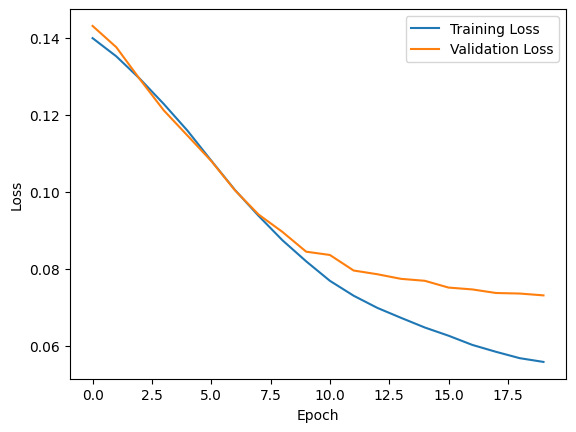

In [68]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Comparing Original ECG vs Prediction

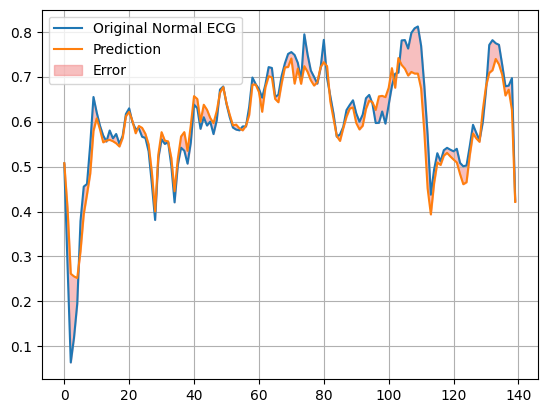

In [72]:
sample = normal_train_data[1500].reshape(1, -1)
sample_pred = model.predict(sample, verbose=0)
plt.plot(np.arange(140), sample[0], label='Original Normal ECG')
plt.plot(np.arange(140), sample_pred[0], label='Prediction')
plt.fill_between(np.arange(140), sample_pred[0], sample[0], color='lightcoral', alpha=0.5, label='Error')
plt.legend()
plt.grid()
plt.show()

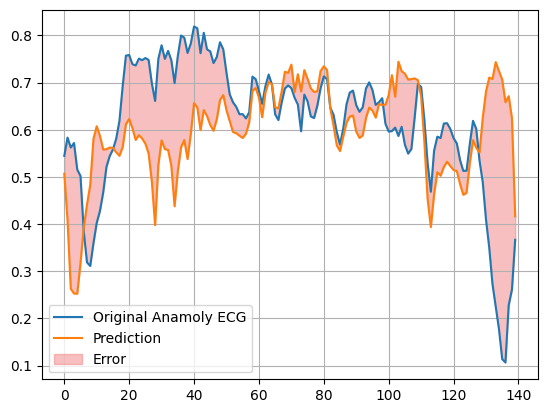

In [73]:
sample = anomaly_train_data[1500].reshape(1, -1)
sample_pred = model.predict(sample, verbose=0)
plt.plot(np.arange(140), sample[0], label='Original Anomaly ECG')
plt.plot(np.arange(140), sample_pred[0], label='Prediction')
plt.fill_between(np.arange(140), sample_pred[0], sample[0], color='lightcoral', alpha=0.5, label='Error')
plt.legend()
plt.grid()
plt.show()

### Finding Loss in Normal Data

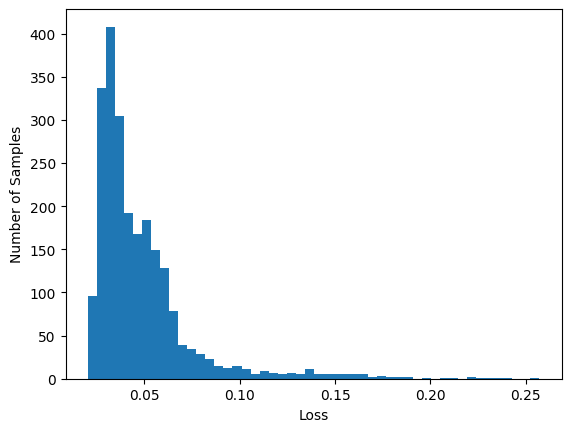

In [74]:
normal_preds = model.predict(normal_train_data, verbose=0)
normal_loss = losses.mae(normal_train_data, normal_preds).numpy()

plt.hist(normal_loss, bins=50)
plt.xlabel('Loss')
plt.ylabel('Number of Samples')
plt.show()

In [75]:
threshold = np.mean(normal_loss) + np.std(normal_loss)
print('Threshold:', threshold)

Threshold: 0.076138094


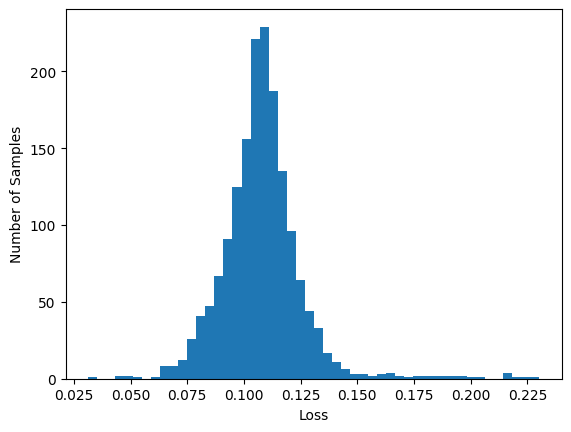

In [76]:
anomaly_preds = model.predict(anomaly_train_data, verbose=0)
anomaly_loss = losses.mae(anomaly_train_data, anomaly_preds).numpy()

plt.hist(anomaly_loss, bins=50)
plt.xlabel('Loss')
plt.ylabel('Number of Samples')
plt.show()

### Defining Prediction Function

In [77]:
def prediction(model, data, threshold):
  preds = model.predict(data, verbose=0)
  loss = losses.mae(data, preds).numpy()
  return np.where(loss < threshold, 1, 0)

def print_metrics(y_true, y_pred):
  print(f"Accuracy: {accuracy_score(y_true, y_pred):.2%}")
  print(f"Precision: {precision_score(y_true, y_pred):.2%}")
  print(f"Recall: {recall_score(y_true, y_pred):.2%}")
  print(f"F1 Score: {f1_score(y_true, y_pred):.2%}")

### Evaluating the Model

In [78]:
preds = prediction(model, X_test, threshold)
print_metrics(y_test, preds)

Accuracy: 94.10%
Precision: 98.19%
Recall: 91.71%
F1 Score: 94.84%
